In [1]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE


In [4]:
class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, string_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(string_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.string_to_index = string_to_index
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            sentence_word_indicies = [self.string_to_index[token] for token in list(sentence)]
            if start_token:
                sentence_word_indicies.insert(0, self.string_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.string_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.string_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for mol in range(len(batch)):
           tokenized.append( tokenize(batch[mol], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


In [6]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out


In [7]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

In [9]:
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

In [10]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 string_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, string_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x

In [11]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


In [13]:
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y


In [14]:
class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 string_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, string_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


In [15]:
class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                vocab_size,
                stoi,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, stoi, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, stoi, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

In [16]:
NEG_INFTY = -1e9

def create_masks(batch_1, batch_2):
    num_sentences = len(batch_1)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      mol1_length, mol2_length = len(batch_1[idx]), len(batch_2[idx])
      encod_to_padding_mask = np.arange(mol1_length + 1, max_sequence_length)
      decode_to_padding_mask = np.arange(mol2_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, encod_to_padding_mask] = True
      encoder_padding_mask[idx, encod_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, decode_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, decode_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, encod_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, decode_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import csv
def extract_column(csv_file, column_index):
    column_values = []
    with open(csv_file, 'r', newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) > column_index:  # Check if the row has enough columns
                column_values.append(row[column_index])
    return column_values

# Example usage:
csv_file_path = '/content/drive/MyDrive/Compounds2.csv'
column_index = 0  # Change this to the index of the column you want to extract (0-indexed)
column_values = extract_column(csv_file_path, column_index)

print(len(column_values))


2316318


In [19]:
num=len(column_values)
maxlen=102
mol_values_all=[]
all=''
column_values=column_values[:100000]

for item in column_values:
  if len(item)<=maxlen-2:
    mol_values_all.append(item)

n=int(0.85*len(mol_values_all))

mol_values=mol_values_all[:n]
mol_values_test=mol_values_all[n:]

print(len(mol_values_all))
print(len(mol_values))
print(len(mol_values[0]))


97201
82620
32


In [20]:
# total_mol=1000
# mol_values=mol_values[:total_mol]
print(mol_values[0])

for i in range(len(mol_values)):
    all+=mol_values[i]
print(len(all))

CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
2827813


In [21]:

START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

chars_1=sorted(list(set(all)))
chars=[]
chars.append(START_TOKEN)
for i in range(len(chars_1)):
  chars.append(chars_1[i])
chars.append(PADDING_TOKEN)
chars.append(END_TOKEN)

vocab_size=len(chars)
print(''.join(chars))
print(vocab_size)


<START>#()+-.123456789=ABCDEFGHIKLMNOPRSTUVWXYZ[]abcdefghiklmnoprstuy<PADDING><END>
65


In [22]:
stoi={ch:i for i,ch in enumerate(chars)}
itos={i:ch for i,ch in enumerate(chars)}
encode=lambda s:[stoi[ch] for ch in s] # takes a string, outputs a list of integers
decode=lambda l: "".join([itos[i] for i in l]) # takes a list of integers, outputs a string

data=torch.tensor(encode(all),dtype=torch.long)
print(data.shape,data.dtype)

torch.Size([2827813]) torch.int64


In [23]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, mol_values):
        self.mol_values = mol_values

    def __len__(self):
        return len(self.mol_values)

    def __getitem__(self, idx):
        return self.mol_values[idx]

In [24]:
dataset = TextDataset(mol_values)
print(len(dataset))
dataset[1]

82620


'CC(=O)OC(CC(=O)O)C[N+](C)(C)C'

In [26]:
# from transformer import Transformer
d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.2
num_layers = 3
max_sequence_length = maxlen
vocab_size = len(chars)

transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          vocab_size,
                          stoi,
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN)

In [27]:
transformer

Transformer(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(65, 512)
      (position_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.2, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): EncoderLayer(
        (attention): MultiHeadAt

In [28]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)


In [29]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    print(batch_num)
    if batch_num > 3:
        break

['CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C', 'CC(=O)OC(CC(=O)O)C[N+](C)(C)C', 'C1=CC(C(C(=C1)C(=O)O)O)O', 'CC(CN)O', 'C(C(=O)COP(=O)(O)O)N', 'C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl', 'CCN1C=NC2=C(N=CN=C21)N', 'CCC(C)(C(C(=O)O)O)O', 'C1(C(C(C(C(C1O)O)OP(=O)(O)O)O)O)O', 'C(CCl)Cl', 'C1=C(C=C(C(=C1O)O)O)O', 'C1=CC(=C(C=C1Cl)Cl)Cl', 'CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O', 'CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C', 'C1CCC(=O)NCCCCCC(=O)NCC1', 'C1C=CC(=NC1C(=O)O)C(=O)O', 'C(C(C(C(=O)C(=O)C(=O)O)O)O)O', 'C1=CC(=C(C(=C1)O)O)C(=O)O', 'C1=CC(=C(C(=C1)O)O)CCC(=O)O', 'CCC(C(=O)C)(C(=O)O)O', 'CC(=O)C(C)(C(=O)O)O', 'C(=CC(=C(C(=O)O)N)C(=O)O)C=O', 'C(=O)C(C(=O)O)N', 'C(C=O)Cl', 'C(CCl)O', 'CC(C)C(C(C(=O)O)O)C(=O)O', 'CC(C)(CO)C(=O)C(=O)O', 'CC1(COC(=O)C1=O)C', 'C1C(C(C(OC1O)CO)O)O', 'C(CC(=O)O)C(=O)C=CC=C(C(=O)O)O']
0
['C(CC(=O)O)C(C(=O)O)O', 'C(C(=O)[O-])(C(=O)[O-])O', 'C(C(=O)O)(C(=O)O)O', 'CCC(C)C(=O)C(=O)O', 'C(CC(=O)N)C(=O)C(=O)O', 'CC(C)C(=O)C(=O)O', 'C(C(C(C(C(=O)C(=O)O)O)O)O)O', 'C(CC(=O)O)C(=O)C(=O

In [30]:
# for i in range(2100,2500):
#   if len(mol_values[i])==100:
#     print("Yes",i)

In [31]:
from torch import nn

criterion = nn.CrossEntropyLoss(ignore_index=stoi[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        # print(batch_num)
        # print(batch)
        transformer.train()
        mol_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(mol_batch,mol_batch)
        optim.zero_grad()
        mol_predictions = transformer(mol_batch,
                                     mol_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(mol_batch, start_token=False, end_token=True)
        loss = criterion(
            mol_predictions.view(-1, vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        # print(mol_predictions)
        # print(labels)
        valid_indices = torch.where(labels.view(-1) == stoi[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indices.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"Input molecule: {batch[0]}")
            # print(f"Output molecule: {batch[0]}")
            mol_predicted = torch.argmax(mol_predictions[0], axis=1)
            predicted_molecule = ""
            # print(mol_predicted)
            for idx in mol_predicted:
              if idx == stoi[END_TOKEN]:
                break
              predicted_molecule += itos[idx.item()]
            print(f"Output Prediction: {predicted_molecule}")


            transformer.eval()
            mol_gen = ("",)
            mol2 = ("CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(mol2, mol_gen)
                predictions = transformer(mol2,
                                          mol_gen,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = itos[next_token_index]
                mol_gen = (mol_gen[0] + next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation output : {mol_gen}")
            print("-------------------------------------------")

Epoch 0
Iteration 0 : 5.044445991516113
Input molecule: CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
Output Prediction: ooo)rMfoffrNff3f)ffoVo31ooo.oooff.ffdM.o)ooo1MdoooooooGG)f1ddr1oo)o)r).odooo..Moor7r)NoT.)dffro)ofofd7
Evaluation output : ('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',)
-------------------------------------------
Iteration 100 : 2.031146287918091
Input molecule: C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)N
Output Prediction: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)COCCCC=C)CCCCC)C)CCCC)CCCCCCCCC))C)CCCCCCCCC)C)OCCCCCCCCCCC)CC
Evaluation output : ('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',)
-------------------------------------------
Iteration 200 : 1.0544569492340088
Input molecule: C=CCCCCCCCCC=O
Output Prediction: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Evaluation output : ('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

KeyboardInterrupt: 

In [33]:
transformer.eval()
def produce_new(new_mol):
  new_mol = (new_mol,)
  gen_mol = ("",)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(new_mol, gen_mol)
    predictions = transformer(new_mol,
                              gen_mol,
                              encoder_self_attention_mask.to(device),
                              decoder_self_attention_mask.to(device),
                              decoder_cross_attention_mask.to(device),
                              enc_start_token=False,
                              enc_end_token=False,
                              dec_start_token=True,
                              dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter]
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = itos[next_token_index]
    gen_mol = (gen_mol[0] + next_token, )
    if next_token == END_TOKEN:
      break
  return gen_mol[0]


In [34]:

!git clone https://github.com/rajkumar1501/drug_analog_data.git
!pip install rdkit-pypi

Cloning into 'drug_analog_data'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (4/4), 4.48 MiB | 33.03 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 28.1 MB/s eta 0:00:00


Enter a chemical SMILES(length < 100): COC(CC=CC=CCCC=CCC(C)C=CC(CC(O)=O)=CC(O)=O)C(C)=CC=C(C)C(O)=O
COC(CC=CC=CCCC=CCC(C)C=CC(CC(O)=O)=CC(O)=O)C(C)=CC=C(C)C(O)=O
Length of the SMILES is 61. The model may not perfom well on SMILES length more than 80.


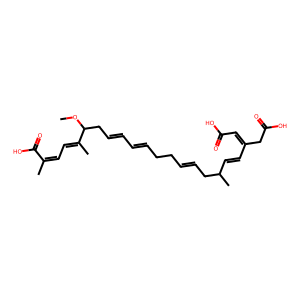

In [35]:
#@title  Enter SMILES
d = input('Enter a chemical SMILES(length < 100): ').strip()
print(d)
from rdkit.Chem import Draw
from rdkit import Chem
mol = Chem.MolFromSmiles(d)

print("Length of the SMILES is " +str(len(d))+". The model may not perfom well on SMILES length more than 80.")
Draw.MolToImage(mol)

The output SMILES is: COC(CC=CC=CCCC=CCC(C)C=CC(CC(O)=O)=CC(O)=O)C(C)=CC=C(C)C(O)=O


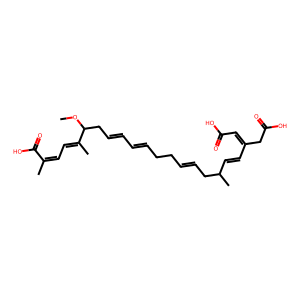

In [36]:
out=produce_new(d)
out=out[:-5]
print("The output SMILES is:", out)

mol = Chem.MolFromSmiles(out)
Draw.MolToImage(mol)